In [24]:
import pandas as pd
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

from collections import defaultdict

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
df = pd.read_csv(r"mtsamples.csv")
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [26]:
df=df[['transcription','medical_specialty']]
df.head()

,transcription,medical_specialty
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary


In [27]:
df['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [28]:
counts = df['medical_specialty'].value_counts()

df = df[~df['medical_specialty'].isin(counts[counts < 100].index)]

df['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
Name: medical_specialty, dtype: int64

In [29]:
df.dropna(axis=0,inplace=True)

df = df[df['medical_specialty'] != ' Surgery']
df = df[df['medical_specialty'] != ' SOAP / Chart / Progress Notes']
# df = df[df['medical_specialty'] != ' Emergency Room Reports']
df = df[df['medical_specialty'] != ' Discharge Summary']
# df = df[df['medical_specialty'] != ' Office Notes']
df = df[df['medical_specialty'] != ' General Medicine']
# df = df[df['medical_specialty'] != ' Pain Management']

df.loc[df.medical_specialty == ' Neurosurgery', "medical_specialty"] = ' Neurology'
df.loc[df.medical_specialty == ' Nephrology', "medical_specialty"] = " Urology"

df['medical_specialty'].value_counts()

 Consult - History and Phy.    516
 Cardiovascular / Pulmonary    371
 Orthopedic                    355
 Radiology                     273
 Gastroenterology              224
 Neurology                     223
 Urology                       156
 Obstetrics / Gynecology       155
Name: medical_specialty, dtype: int64

In [30]:
print('Sample transcription 1:'+df.iloc[4]['transcription']+'\n')
print('Sample transcription 2:'+df.iloc[14]['transcription']+'\n')

Sample transcription 1:2-D STUDY,1. Mild aortic stenosis, widely calcified, minimally restricted.,2. Mild left ventricular hypertrophy but normal systolic function.,3. Moderate biatrial enlargement.,4. Normal right ventricle.,5. Normal appearance of the tricuspid and mitral valves.,6. Normal left ventricle and left ventricular systolic function.,DOPPLER,1. There is 1 to 2+ aortic regurgitation easily seen, but no aortic stenosis.,2. Mild tricuspid regurgitation with only mild increase in right heart pressures, 30-35 mmHg maximum.,SUMMARY,1. Normal left ventricle.,2. Moderate biatrial enlargement.,3. Mild tricuspid regurgitation, but only mild increase in right heart pressures.

Sample transcription 2:PREOPERATIVE DIAGNOSIS: , Umbilical hernia.,POSTOPERATIVE DIAGNOSIS: , Umbilical hernia.,PROCEDURE PERFORMED: , Repair of umbilical hernia.,ANESTHESIA: , General.,COMPLICATIONS: , None.,ESTIMATED BLOOD LOSS: , Minimal.,PROCEDURE IN DETAIL:  ,The patient was prepped and draped in the steril

In [31]:
special_character_remover = re.compile('[/(){}\[\]\|@,;]')
extra_symbol_remover = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [32]:
def clean_text(text):
    text = text.lower()
    text = special_character_remover.sub(' ',text)
    text = extra_symbol_remover.sub('',text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))    
    return ' '.join(wordlist) 

In [33]:
df['transcription'] = df['transcription'].apply(clean_text)
df['transcription'] = df['transcription'].apply(lemmatize_text)

In [34]:
print('Sample Transcription 1:'+df.iloc[4]['transcription']+'\n')
print('Sample Transcription 2:'+df.iloc[14]['transcription']+'\n')

Sample Transcription 1:2d study 1 mild aortic stenosis widely calcified minimally restricted 2 mild left ventricular hypertrophy normal systolic function 3 moderate biatrial enlargement 4 normal right ventricle 5 normal appearance tricuspid mitral valve 6 normal left ventricle left ventricular systolic function doppler 1 1 2+ aortic regurgitation easily seen aortic stenosis 2 mild tricuspid regurgitation mild increase right heart pressure 3035 mmhg maximum summary 1 normal left ventricle 2 moderate biatrial enlargement 3 mild tricuspid regurgitation mild increase right heart pressure

Sample Transcription 2:preoperative diagnosis umbilical hernia postoperative diagnosis umbilical hernia procedure performed repair umbilical hernia anesthesia general complication none estimated blood loss minimal procedure detail patient prepped draped sterile fashion infraumbilical incision formed taken fascia umbilical hernia carefully reduced back cavity fascia closed interrupted vertical mattress sut

In [35]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1,3), max_df=0.75, min_df=5, use_idf=True, smooth_idf=True, sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(df['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
del feature_names[0:38]

print(feature_names)

['abc', 'abcd', 'abdomen', 'abdomen soft', 'abdomen soft nontender', 'abdominal', 'abdominal pain', 'able', 'abnormal', 'abnormality', 'abuse', 'achieved', 'active', 'activity', 'acute', 'acute distress', 'addition', 'additional', 'adenopathy', 'adequate', 'adhesion', 'administered', 'admission', 'admitted', 'advanced', 'age', 'ago', 'air', 'alcohol', 'alert', 'alert oriented', 'allergy', 'allergy known', 'allergy known drug', 'anastomosis', 'anemia', 'anesthesia', 'anesthesia general', 'anesthetic', 'angiogram', 'ankle', 'anterior', 'anterior descending', 'antibiotic', 'aorta', 'aortic', 'aortic valve', 'apparently', 'appear', 'appearance', 'appeared', 'appears', 'applied', 'appropriate', 'approximately', 'area', 'arm', 'artery', 'artery disease', 'arthritis', 'asked', 'aspect', 'aspirin', 'assessment', 'associated', 'atraumatic', 'atrial', 'atrial fibrillation', 'attention', 'auscultation', 'axis', 'balloon', 'base', 'based', 'bed', 'began', 'benefit', 'benign', 'better', 'bid', 'bil

In [36]:
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = df['medical_specialty'].tolist()
category_list = df.medical_specialty.unique()

In [37]:
x_train, x_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels, random_state=1)   

In [38]:
print('Train_Set_Size:'+str(x_train.shape))
print('Test_Set_Size:'+str(x_test.shape))

Train_Set_Size:(1704, 596)
Test_Set_Size:(569, 596)


In [39]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB().fit(x_train, y_train)
NB_y_pred = NB.predict(x_test)

print("Naive Bayes Accuracy Score -> ", accuracy_score(NB_y_pred, y_test)*100)

Naive Bayes Accuracy Score ->  55.008787346221446


In [41]:
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier(alpha=1, max_iter=1000).fit(x_train, y_train)

MLP_y_pred = MLP.predict(x_test)

print("MLP Accuracy Score -> ", accuracy_score(MLP_y_pred, y_test)*100)

MLP Accuracy Score ->  59.57820738137083


In [40]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier().fit(x_train, y_train)

KNN_y_pred = KNN.predict(x_test)

print("K Nearest Neighbour Accuracy Score -> ", accuracy_score(KNN_y_pred, y_test)*100)

K Nearest Neighbour Accuracy Score ->  60.28119507908612


In [42]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=1).fit(x_train, y_train)
LR_y_pred = LR.predict(x_test)

print("Logistic Regression Accuracy Score -> ", accuracy_score(LR_y_pred, y_test)*100)

Logistic Regression Accuracy Score ->  64.32337434094903


In [43]:
print(classification_report(y_test, MLP_y_pred, labels=category_list))

                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.65      0.66      0.65        93
                  Neurology       0.29      0.20      0.23        56
                    Urology       0.86      0.64      0.74        39
                  Radiology       0.27      0.26      0.27        68
                 Orthopedic       0.76      0.72      0.74        89
    Obstetrics / Gynecology       0.83      0.62      0.71        39
           Gastroenterology       0.71      0.64      0.67        56
 Consult - History and Phy.       0.56      0.78      0.65       129

                   accuracy                           0.60       569
                  macro avg       0.62      0.56      0.58       569
               weighted avg       0.60      0.60      0.59       569



Text(0.5, 1.0, 'CONFUSION MATRIX - Logistic Regression')

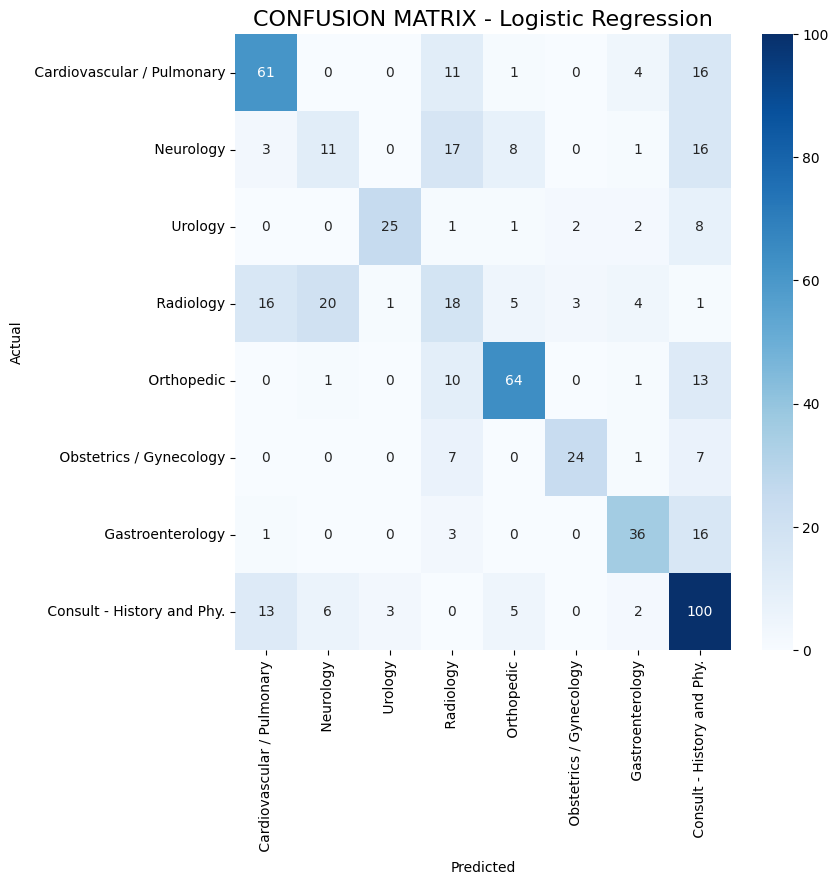

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, MLP_y_pred, labels=category_list)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_list, 
            yticklabels=category_list)
            
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistic Regression", size=16)